# Changes from v1: 
#####  1. Switched to LeakyReLU (from ReLU) on generator. 

# Changes from v2: 
#####  1. Backpropagated Discriminator gradients only if Loss_d > Threshold. 

# Changes from v3: 
#####  1. D_loss threshold = 0.2,
#####  2. Backpropagated Generator gradients only if Loss_g > Threshold. 
#####  G_loss threshold = 4. 

In [1]:
import os

DATA_DIR = 'C:/Users/yigii/OneDrive/Masaüstü/python_projects/portfolioprojects/gan/animefaces/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

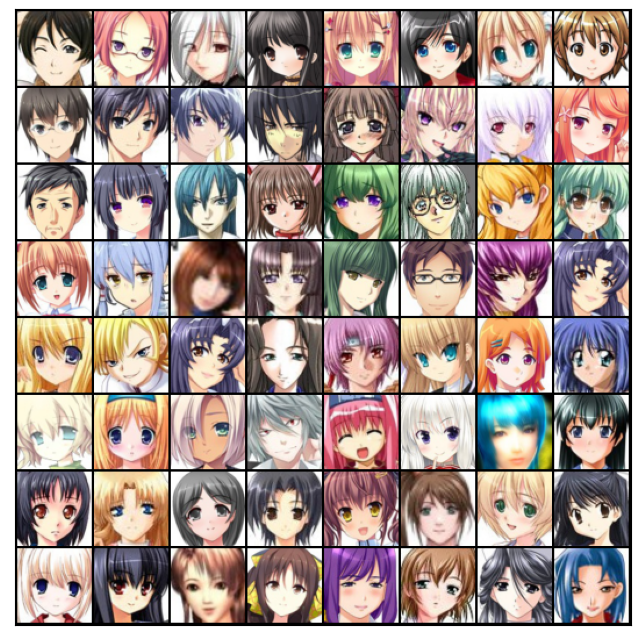

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


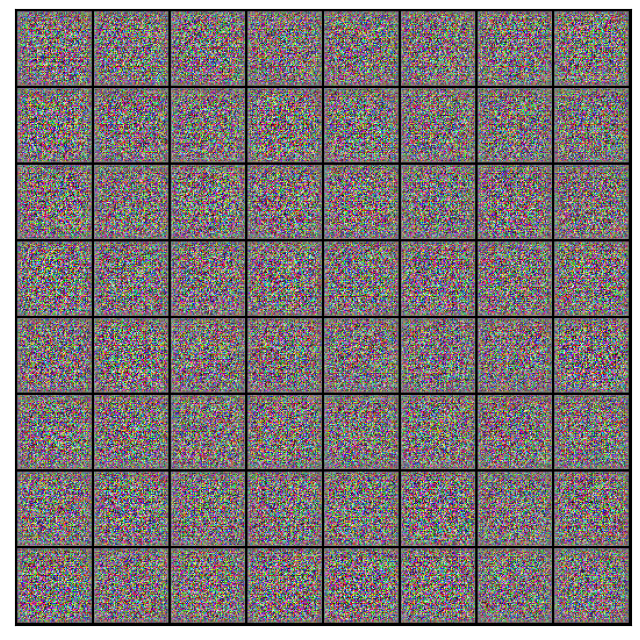

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d, d_loss_threshold=0.2):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights only if loss is greater than threshold
    loss = real_loss + fake_loss
    if loss > d_loss_threshold:
        loss.backward()
        opt_d.step()

    return loss.item(), real_score, fake_score


In [20]:
def train_generator(opt_g, g_loss_threshold=4.):
    while True:
        # Clear generator gradients
        opt_g.zero_grad()

        # Generate fake images
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(latent)

        # Try to fool the discriminator
        preds = discriminator(fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss = F.binary_cross_entropy(preds, targets)
        
        # Update generator weights
        loss.backward()
        opt_g.step()
        
        if loss < g_loss_threshold:
            break
            
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


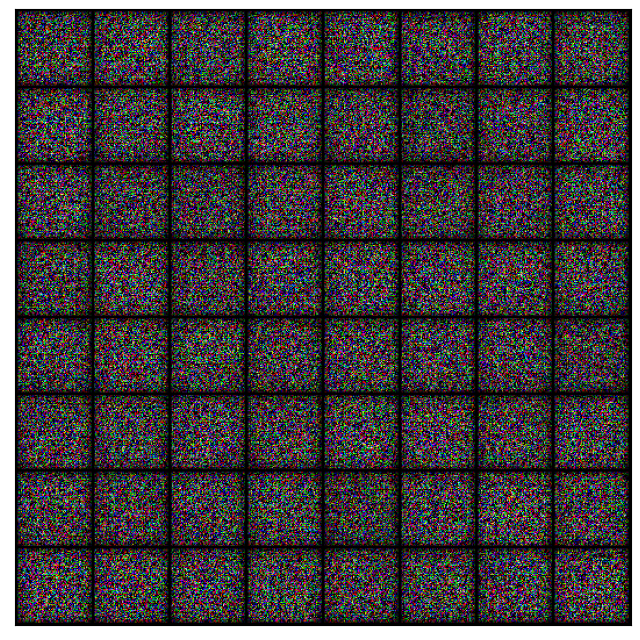

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 50

In [29]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 3.5793, loss_d: 0.6540, real_score: 0.8345, fake_score: 0.3548
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.6416, loss_d: 1.6329, real_score: 0.9121, fake_score: 0.7425
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 2.2374, loss_d: 0.4190, real_score: 0.7650, fake_score: 0.1121
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.0106, loss_d: 0.5650, real_score: 0.6821, fake_score: 0.1190
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.1166, loss_d: 0.3334, real_score: 0.8577, fake_score: 0.1504
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.7747, loss_d: 0.3643, real_score: 0.8489, fake_score: 0.1583
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.1252, loss_d: 0.6598, real_score: 0.8703, fake_score: 0.3590
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.5457, loss_d: 0.4664, real_score: 0.8725, fake_score: 0.2516
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.8455, loss_d: 0.2450, real_score: 0.9017, fake_score: 0.1198
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 0.7093, loss_d: 1.4440, real_score: 0.3206, fake_score: 0.0680
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.7585, loss_d: 0.2133, real_score: 0.9128, fake_score: 0.1047
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 2.1418, loss_d: 0.4574, real_score: 0.7481, fake_score: 0.1093
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.3262, loss_d: 0.2718, real_score: 0.8916, fake_score: 0.1237
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 1.2117, loss_d: 1.5064, real_score: 0.2901, fake_score: 0.0444
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 2.1712, loss_d: 0.2533, real_score: 0.8299, fake_score: 0.0419
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 0.8394, loss_d: 2.7452, real_score: 0.1046, fake_score: 0.0499
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.1192, loss_d: 0.3306, real_score: 0.7867, fake_score: 0.0602
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.7402, loss_d: 1.9732, real_score: 0.9784, fake_score: 0.8141
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.4263, loss_d: 0.2352, real_score: 0.8870, fake_score: 0.0922
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.8680, loss_d: 0.2266, real_score: 0.9541, fake_score: 0.1525
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.7100, loss_d: 0.2364, real_score: 0.8333, fake_score: 0.0372
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.8903, loss_d: 0.1913, real_score: 0.9088, fake_score: 0.0844
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 1.1524, loss_d: 1.7178, real_score: 0.2838, fake_score: 0.0534
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.7553, loss_d: 0.2673, real_score: 0.8730, fake_score: 0.1082
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.4032, loss_d: 0.1961, real_score: 0.9259, fake_score: 0.1025
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.6671, loss_d: 0.3389, real_score: 0.9625, fake_score: 0.2372
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.8104, loss_d: 0.2658, real_score: 0.9764, fake_score: 0.1924
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.5172, loss_d: 0.2192, real_score: 0.8993, fake_score: 0.0904
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.2523, loss_d: 0.3481, real_score: 0.8773, fake_score: 0.1451
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.0567, loss_d: 0.1298, real_score: 0.9348, fake_score: 0.0472
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.5459, loss_d: 1.0391, real_score: 0.6802, fake_score: 0.2607
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.3551, loss_d: 0.3550, real_score: 0.9462, fake_score: 0.2495
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 2.9642, loss_d: 1.1024, real_score: 0.5780, fake_score: 0.1273
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 2.1512, loss_d: 0.1490, real_score: 0.9549, fake_score: 0.0918
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.1241, loss_d: 0.3564, real_score: 0.9138, fake_score: 0.1815
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.2931, loss_d: 0.5211, real_score: 0.9117, fake_score: 0.3266
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.4561, loss_d: 0.6709, real_score: 0.7357, fake_score: 0.1651
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.2222, loss_d: 0.5121, real_score: 0.7745, fake_score: 0.0965
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.9949, loss_d: 0.3333, real_score: 0.9254, fake_score: 0.1951
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.8191, loss_d: 0.3176, real_score: 0.8821, fake_score: 0.1285
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.6960, loss_d: 0.3463, real_score: 0.8385, fake_score: 0.1083
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.7304, loss_d: 0.2341, real_score: 0.8821, fake_score: 0.0751
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.0651, loss_d: 0.2549, real_score: 0.8758, fake_score: 0.0823
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.9397, loss_d: 0.3289, real_score: 0.9309, fake_score: 0.2092
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 2.4397, loss_d: 0.1633, real_score: 0.9652, fake_score: 0.1112
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.9153, loss_d: 0.7897, real_score: 0.7193, fake_score: 0.2510
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.2387, loss_d: 0.2795, real_score: 0.8762, fake_score: 0.0597
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.7301, loss_d: 0.2478, real_score: 0.8761, fake_score: 0.0813
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 3.4032, loss_d: 0.1466, real_score: 0.9707, fake_score: 0.1040
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.9671, loss_d: 0.8137, real_score: 0.6619, fake_score: 0.1534
Saving generated-images-0050.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

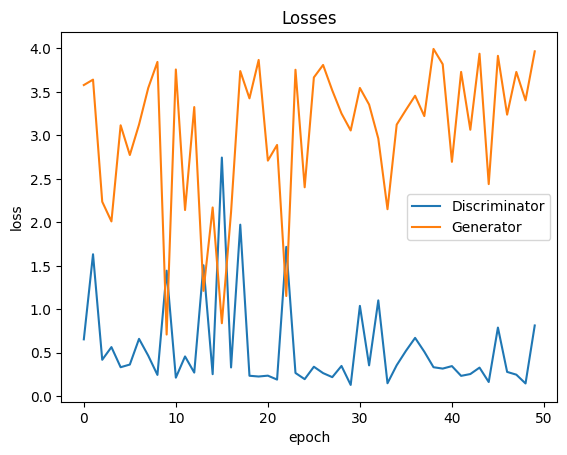

In [31]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

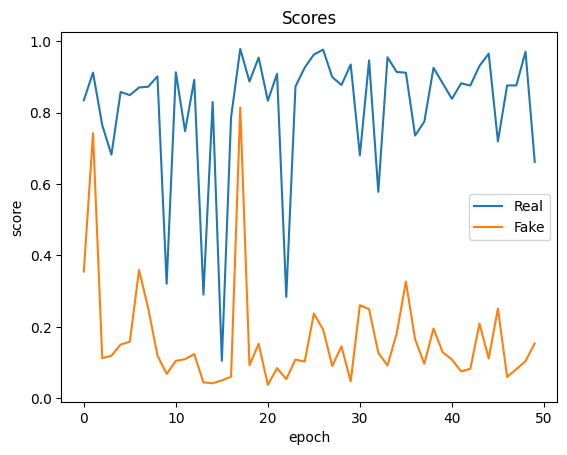

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [33]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gv4.3.pth')
torch.save(discriminator.state_dict(), 'Dv4.3.pth')

In [34]:
import cv2
import os

vid_fname = 'gans_training_v4.3.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [35]:
from IPython.display import Image

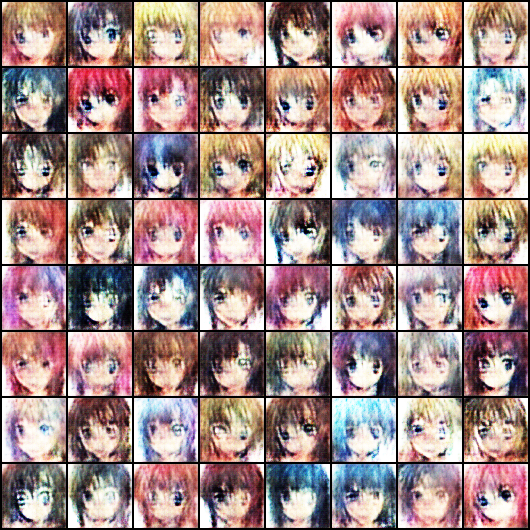

In [36]:
Image('./generated/generated-images-0001.png')

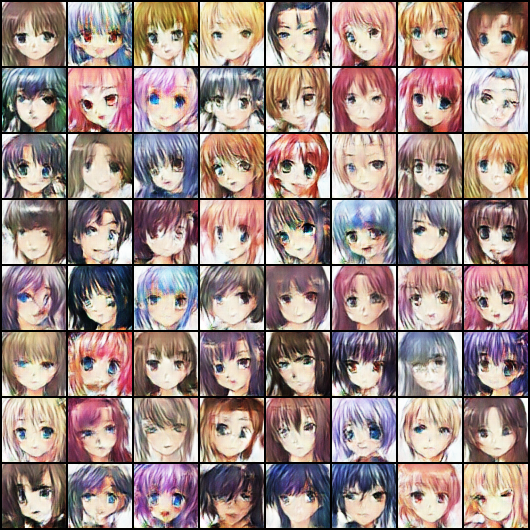

In [37]:
Image('./generated/generated-images-0010.png')

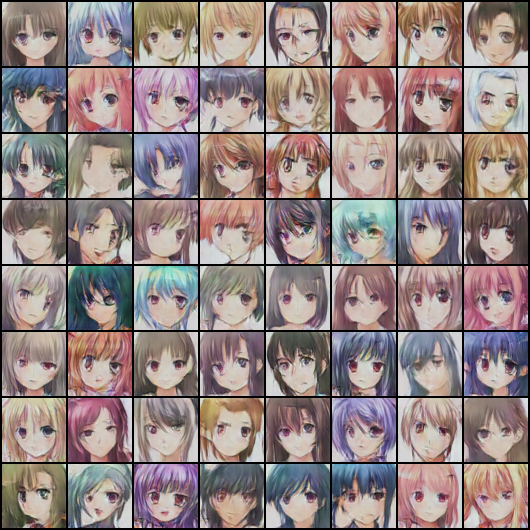

In [38]:
Image('./generated/generated-images-0025.png')

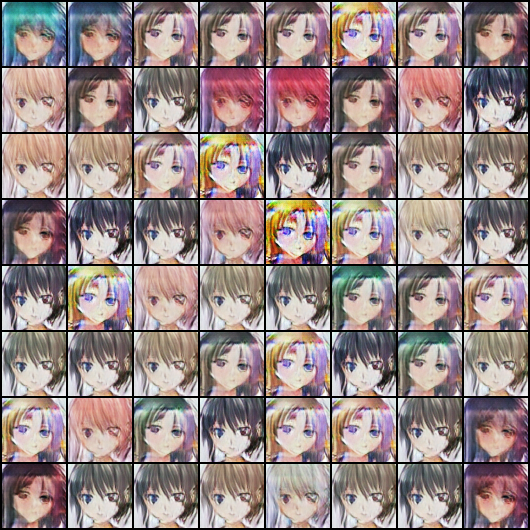

In [39]:
Image('./generated/generated-images-0050.png')

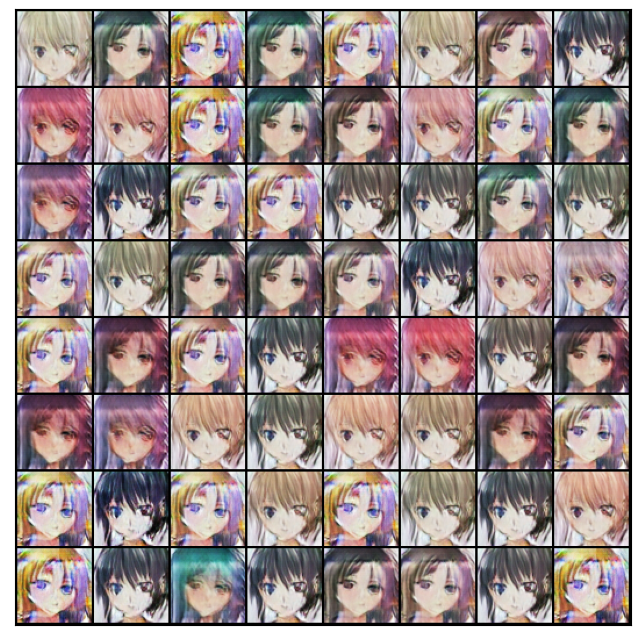

In [40]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))